In [1]:
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/siddeshlc8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/siddeshlc8/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siddeshlc8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import string
import re
import numpy as np
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import pandas as pd
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import cross_validate as cross_validation, ShuffleSplit, cross_val_score
import nltk
import warnings
warnings.filterwarnings("ignore")

In [3]:
def labelStance(labelDict, data):
	for key, val in labelDict.items():
		data.loc[data["Stance"] == val, "Stance"] = int(key)
	return data

def readGlobalVecData(glove_word_vec_file):
	file = open(glove_word_vec_file, 'r')
	rawData = file.readlines()
	glove_word_vec_dict = {}
	for line in rawData:
		line = line.strip().split()
		tag = line[0]
		vec = line[1:]
		glove_word_vec_dict[tag] = np.array(vec, dtype=float)
	return glove_word_vec_dict
  
classifiers = ['Support Vector Machine', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'Logistic Regression', 'Neural Network', 'Gaussian NB', 'K Neighbors Classifier', 'Decision Tree Classifier']

training = "Dataset-SemEval2016/training.txt"
test = "Dataset-SemEval2016/test-gold.txt"

gloveFile = "/home/siddeshlc8/siddeshlc/Glove Vectorization/glove.twitter.27B.200d.txt"

print("\nLoading Glove data...")
glove_word_vec_dict = readGlobalVecData(gloveFile)

trainTweets = pd.read_csv(training, sep='\t',header=0,encoding='utf-8')
testTweets = pd.read_csv(test, sep='\t',header=0,encoding='utf-8')
uniqTrainTargets = trainTweets.Target.unique()

#For converting all the stances into numerical values in both training and test data
labelDict = {0:"AGAINST", 1:"FAVOR", 2:"NONE"}
trainTweets = labelStance(labelDict, trainTweets)
testTweets = labelStance(labelDict, testTweets)


Loading Glove data...


In [14]:
def getWordVector(word, glove_word_vec_dict):
	if word in glove_word_vec_dict:
		return glove_word_vec_dict[word]
	return np.zeros_like(glove_word_vec_dict["dummy"])

def sumVectors(finalList, glove_word_vec_dict):
	numNonZero = 0
	vector = np.zeros_like(glove_word_vec_dict["dummy"])
	for word in finalList:
		vect = getWordVector(word,glove_word_vec_dict)
		if vect.sum() != 0:
			vector += vect
			numNonZero += 1
	if numNonZero:
		vector = vector/numNonZero
	return vector

def simplify(word):
	dump = ''
	temp = []
	listOfWords = list(filter(None,re.split("([A-Z][^A-Z]*)",word)))
	if len(listOfWords) == len(word):
		return word.lower()
	for i in range(len(listOfWords)):
		listOfWords[i] = listOfWords[i].lower()
		if len(listOfWords[i]) == 1:
			dump = dump + listOfWords[i]
			if dump in words.words() and len(dump) > 2:
				temp.append(dump)
				dump = ''
		else:
			temp.append(listOfWords[i])
	return temp

def glove(glove_word_vec_dict, trainTweets, testTweets):
    def createTokens(data,glove_word_vec_dict):
        listOfTweets = []
        listOfStances = []
        tweetVector = []
        for ind, row in data.iterrows():
            # Create a sentence using target and the tweet. Word vector will be formed from this.
            example_sentence = str(row["Target"]) +' ' + str(row["Tweet"])
            # Remove punctuation
            final_sentence = example_sentence.translate(string.punctuation)
            wordList = word_tokenize(final_sentence)
            finalList = []
            s = ' '.join([i for i in wordList if i.isalpha()])
            # create tokens from the string and stem them
            wordList = word_tokenize(s)
            wordList = [w.lower() for w in wordList]
            stop_words = set(stopwords.words('english'))
            wordList = [w for w in wordList if not w in stop_words]
            for word in wordList:
                #to break any combined word into its components for eg, hashtags
                finalList += simplify(word)
            final_sentence = ' '.join(finalList)
            listOfTweets.append(final_sentence)
            listOfStances.append(row["Stance"])
            tweetVector.append(sumVectors(finalList,glove_word_vec_dict))
        return listOfTweets, listOfStances, tweetVector
    # Remove punctuation from and tokenize the training tweets
    listOfTweets, listOfStances, trainTweetVector = createTokens(trainTweets, glove_word_vec_dict)
    # Remove punctuation from and tokenize the test tweets
    listOfTestTweets, listOfTestStances, testTweetVector = createTokens(testTweets, glove_word_vec_dict)
    Xtrain = np.asarray(trainTweetVector)
    Ytrain = np.asarray(listOfStances)
    Xtest = np.asarray(testTweetVector)
    Ytest = np.asarray(listOfTestStances)
    return Xtrain, Ytrain, Xtest, Ytest

totalAcc = []
Targetacc = []
for classifier in classifiers:
  print("\nThe Machine Learning Model Used For Classification : " + classifier)
  temp = []
  total = 0
  for target in uniqTrainTargets:
    Xtrain, Ytrain, Xtest, Ytest = glove(glove_word_vec_dict, 
                                                   trainTweets[trainTweets["Target"]==target], 
                                                   testTweets[testTweets["Target"]==target])

    if classifier == 'Support Vector Machine':
      clf = SVC(kernel="rbf").fit(Xtrain, Ytrain)

    elif classifier == 'Random Forest Classifier':
      clf = RandomForestClassifier(n_estimators=90).fit(Xtrain, Ytrain)

    elif classifier == 'Gradient Boosting Classifier':
      clf = GradientBoostingClassifier().fit(Xtrain, Ytrain)

    elif classifier == 'Logistic Regression':
      clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(Xtrain, Ytrain)

    elif classifier == 'Neural Network':
      clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(Xtrain, Ytrain)

    elif classifier == 'Gaussian NB':
      clf = GaussianNB().fit(Xtrain, Ytrain)

    elif classifier == 'K Neighbors Classifier':
      clf = GaussianNB().fit(Xtrain, Ytrain)

    elif classifier == 'Decision Tree Classifier':
      clf = tree.DecisionTreeClassifier().fit(Xtrain, Ytrain)

    acc = clf.score(Xtest, Ytest)
#     print("Test Accuracy is "+ str(round(acc*100,2)) +"%")
    total = total + acc
    temp.append(acc)
    
  Targetacc.append(temp)
  total = total/len(uniqTrainTargets)
  print("\nTotal Test Accuracy is "+ str(round(total*100,2)) +"%")
  totalAcc.append(total)


The Machine Learning Model Used For Classification : Support Vector Machine

Total Test Accuracy is 67.1%

The Machine Learning Model Used For Classification : Random Forest Classifier

Total Test Accuracy is 67.55%

The Machine Learning Model Used For Classification : Gradient Boosting Classifier

Total Test Accuracy is 65.0%

The Machine Learning Model Used For Classification : Logistic Regression

Total Test Accuracy is 65.33%

The Machine Learning Model Used For Classification : Neural Network

Total Test Accuracy is 67.1%

The Machine Learning Model Used For Classification : Gaussian NB

Total Test Accuracy is 59.18%

The Machine Learning Model Used For Classification : K Neighbors Classifier

Total Test Accuracy is 59.18%

The Machine Learning Model Used For Classification : Decision Tree Classifier

Total Test Accuracy is 53.92%


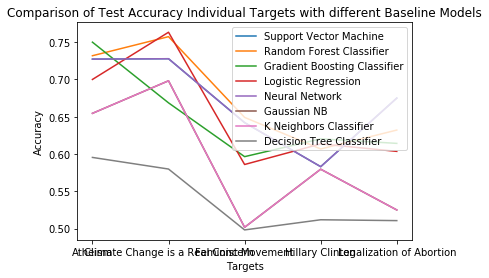

In [17]:
import matplotlib.pyplot as plt

x  = uniqTrainTargets
y  = Targetacc

for i in range(0,len(y)):
    plt.plot(x, y[i], label=classifiers[i])
plt.plot()

plt.xlabel("Targets")
plt.ylabel("Accuracy")
plt.title("Comparison of Test Accuracy Individual Targets with different Baseline Models")
plt.legend()
plt.show()

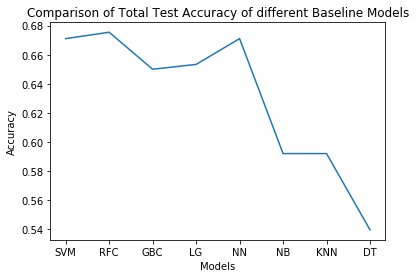

In [18]:
import matplotlib.pyplot as plt

x  = ['SVM', 'RFC', 'GBC', 'LG', 'NN', 'NB', 'KNN', 'DT']
y  = totalAcc

plt.plot(x, y)
plt.plot()

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Total Test Accuracy of different Baseline Models")
plt.show()